Simple kriging assumes that the mean of the random variable is known and constant across the entire study area. This is a strong assumption, that may not be valid for complex spatial datasets. The predictions made by simple kriging are based on take into account the difference between observed values and the global mean, weighting these differences based on the spatial correlation using a semivariogram, to then predict values at unsampled locations.

The main assumption of simple kriging is that the random variable (detrended or not) is stationary.

In [323]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


In [324]:
def spherical_model(h,n,s,r):
    """Function that implements a spehrical semivariogram model."""
    
    # Calculate the semivariance (g is for gamma)
    g = n + (s-n)*( (3*h)/(2*r)  - 1/2*(h/r)**3)
    g[h>r] = s
    g = np.maximum(g, 0)
    return g

In [325]:
nugget = 0
sill = 0.78
range_ = 4141

# Example for a single point

Before we do any spatial interpolation, let's learn about the inner workings of simple kriging. More advanced kriging methods stem from the same principles, albeits some minor modifications to capture local variability (ordinary kriging) or systematic trends (regression kriging)

#### Define observation dataset

In [364]:
# Example coordinates
x_obs = np.array([880, 2700, 3700, 2300, 950, 500])
y_obs = np.array([3700, 4300, 5000, 5650, 5100, 4950])

# Example of porosity observations for x,y coordinates
z_obs = np.array([13.84, 12.15, 12.87, 12.68, 14.41, 14.59])

# Population mean
mu = np.mean(z_obs)

#### Define coordinates of prediction points

This are the *x* and *y* coordinates of points with unknon variable value where we want to make predictions.

In [336]:
# Point coordinates where we want to estimate the variable
x_pred = np.array([2000]) # meters
y_pred = np.array([4700]) # meters


In [337]:
# Convert vectors into pairwise arrays
# so that we meet the requirements of spatial function libraries
obs_points = np.vstack((x_obs, y_obs)).T
pred_points = np.vstack((x_pred, y_pred)).T

print(obs_points)

[[ 880 3700]
 [2700 4300]
 [3700 5000]
 [2300 5650]
 [ 950 5100]
 [ 500 4950]]


### Compute lag distances between all observed points

In [338]:
# Compute lag distance among all observed points
h_obs = np.round(cdist(obs_points, obs_points))
h_obs

array([[   0., 1916., 3105., 2412., 1402., 1306.],
       [1916.,    0., 1221., 1408., 1924., 2294.],
       [3105., 1221.,    0., 1544., 2752., 3200.],
       [2412., 1408., 1544.,    0., 1458., 1931.],
       [1402., 1924., 2752., 1458.,    0.,  474.],
       [1306., 2294., 3200., 1931.,  474.,    0.]])

In [339]:
### Compute lag distances between all observed points and prediction points

In [340]:
# Compute lag distance among all observed points
h_pred = np.round(cdist(obs_points, pred_points))
k = np.round(sill - spherical_model(h_pred,n=nugget,s=sill,r=range_),2)
k

array([[0.37],
       [0.56],
       [0.32],
       [0.5 ],
       [0.47],
       [0.37]])

### Compute covariance matrix

In [341]:
# Covariance matrix
K = np.round(sill - spherical_model(h_obs, n=nugget, s=sill, r=range_), 2)
K

array([[0.78, 0.28, 0.07, 0.18, 0.4 , 0.42],
       [0.28, 0.78, 0.45, 0.4 , 0.28, 0.2 ],
       [0.07, 0.45, 0.78, 0.36, 0.12, 0.06],
       [0.18, 0.4 , 0.36, 0.78, 0.39, 0.27],
       [0.4 , 0.28, 0.12, 0.39, 0.78, 0.65],
       [0.42, 0.2 , 0.06, 0.27, 0.65, 0.78]])

### Compute kriging weights

In [342]:
# kriging weights
lmd = np.dot(np.linalg.inv(K),k)
lmd

array([[ 0.12542978],
       [ 0.46726265],
       [-0.03056315],
       [ 0.26383161],
       [ 0.25613684],
       [-0.01541376]])

### Compute residuals

In [343]:
# Residuals
res_obs = z_obs - mu
res_obs

array([ 0.41666667, -1.27333333, -0.55333333, -0.74333333,  0.98666667,
        1.16666667])

In [344]:
# Residual at prediction point (deviation from the global or local mean)
res_pred = np.dot(lmd.T, res_obs)
res_pred

array([-0.48718296])

### Estimate value and variance at prediction point

In [345]:
# Mean value at prediction point
z_pred = mu + res_pred
z_pred

array([12.93615037])

In [346]:
# Compute variance at prediction (unsampled) location
# We need to get the diagonal (which is the variance at each point)
v_pred = sill - np.dot(lmd.T,k)
v_pred[np.identity(v_pred.shape[0], dtype=bool)]


array([0.23510707])

In [347]:
# Standard deviation
np.sqrt(v_pred)


array([[0.48487841]])

## Create function

In [348]:
def simple_kriging(x_obs,y_obs,z_obs,x_pred,y_pred,semivariogram,par,mu=None):
    """
    Function that interpolates values at known observation 
    points to unknown points using simple kriging.
    
    All inputs: x_obs, y_obs, z_obs, x_pred, and y_pred are vectors.
    
    Returns the predicted value and the variance.
    """
    
    # Get semivariogram parameters
    nugget = par[0]
    sill = par[1]
    range_ = par[2]
    
    # Compute global mean if not provided
    if mu is None:
        mu = np.nanmean(z_obs)
    
    # Create point arrays in the format required by the cdist function
    obs_points = np.vstack((x_obs, y_obs)).T
    pred_points = np.vstack((x_pred, y_pred)).T

    # Compute distance between each pair of observed.
    h_obs = cdist(obs_points, obs_points)

    # Covariance matrix for all observed points
    K = sill - semivariogram(h_obs, n=nugget, s=sill, r=range_)
    
    # Residuals of the observed values relative tot he global mean
    res_obs = z_obs - mu
        
    # Distance from prediction points to all observed points
    h_pred = cdist(obs_points, pred_points)

    # Covariance at prediction point
    k = sill - semivariogram(h_pred, n=nugget, s=sill, r=range_)

    # kriging weights
    lmd = np.dot(np.linalg.inv(K), k)

    # Residual at prediction point (deviation from the global or local mean)
    res_pred = np.dot(lmd.T, res_obs)

    # Mean value at prediction point
    z_pred = mu + res_pred

    # Compute variance at prediction (unsampled) location
    v_pred = sill - np.dot(lmd.T, k)
    
    # Get diagonal of covariance matrix
    v_pred = v_pred[np.identity(v_pred.shape[0], dtype=bool)]
    
    return z_pred, v_pred


In [349]:
# Call the function with same inpit data
simple_kriging(x_obs,y_obs,z_obs,x_pred,y_pred, spherical_model,[nugget,sill,range_], mu=mu)

(array([12.94343464]), array([0.23315372]))

## Example for multiple points using real dataset

In [350]:
# Import additional modules
import pandas as pd
import geopandas as gpd
from scipy.optimize import curve_fit


In [351]:
# Define coordiante reference systems
crs_utm = 32614 # UTM Zone 14
crs_wgs = 4326 # WGS84

In [352]:
# Read dataset
df = pd.read_csv('../datasets/spatial/soil_moisture_surveys/kona_15_jul_2019.csv')

# Inspect a few rows
df.head(3)

,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor
0,7/15/2019 7:15,320,ZONE 00001,39.11060,-96.61089,38.88,1.6988,1.8181,23.8419,CD659 12cm rods,3543
1,7/15/2019 7:17,321,"ZONE 00001, ZONE 00011",39.11058,-96.61116,41.71,1.7474,1.8310,26.7794,CD659 12cm rods,3543
2,7/15/2019 7:17,322,"ZONE 00001, ZONE 00011",39.11055,-96.61146,40.59,1.7271,1.7911,25.5712,CD659 12cm rods,3543


In [353]:
# Drop lines with NaN in 'Moisture' column
df.dropna(subset='Moisture', inplace=True)
df.reset_index(drop=True, inplace=True)


In [354]:
# Convert Dataframe to GeoDataframe
gdf = gpd.GeoDataFrame(df)


In [355]:
# Add Point geometry from lat and long values
gdf['points'] = gpd.points_from_xy(gdf['Longitude'], gdf['Latitude'])
gdf.set_geometry('points', drop=True, inplace=True, crs=crs_wgs)


In [356]:
# Convert point coordinates to UTM, so that we can work in meters
# to compute distances within the field
gdf.to_crs(crs=crs_utm, inplace=True)


In [357]:
# Get values of longitude (x) and latitude (y) in meters
x_obs = gdf['geometry'].x.values
y_obs = gdf['geometry'].y.values
z_obs = gdf['Moisture'].values


In [358]:
# Generate grid
x_vec = np.linspace(x_obs.min(), x_obs.max(), num=50)
y_vec = np.linspace(y_obs.min(), y_obs.max(), num=50)

# Create grid
X_pred, Y_pred = np.meshgrid(x_vec, y_vec)


In [359]:

# Define simple linear model for removing the main trend in a dataset
detrend_model = lambda data,b0,b1,b2: b0 + b1*data[0] + b2*data[1]

# Fit simple detrend model to data
popt, pcov = curve_fit(detrend_model,[x_obs,y_obs],z_obs)
print(popt)

# Create trend surface using observed x and y coordinates
z_trend = detrend_model([x_obs,y_obs], *popt)

# Remove trend from data (resulting in residuals)
z_res = z_obs - z_trend


[-4.67047351e+04  2.96492268e-02  5.95374753e-03]


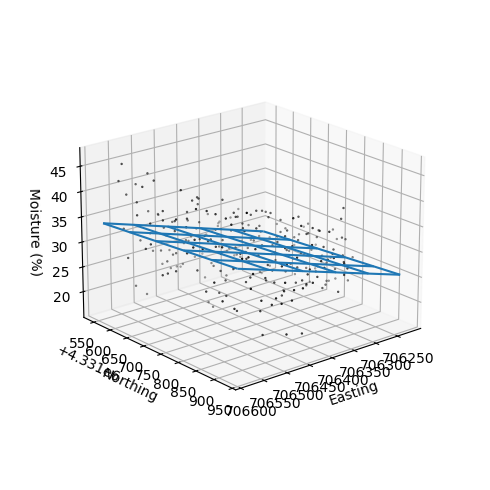

In [360]:
# Inspect data and fitted trend

# Compute moisture values for each grid point
Z_trend = detrend_model([X_pred,Y_pred], *popt)

# Plot
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(x_obs, y_obs, z_obs, s=2, marker='.', facecolor='None', edgecolor='k')
ax.plot_wireframe(X_pred, Y_pred, Z_trend, rstride=10, cstride=10)
ax.view_init(elev=20, azim=50)
ax.set_box_aspect(aspect=None, zoom=0.8)
fig.tight_layout()
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Moisture (%)')
plt.show()


In [361]:
nugget = 2.23
sill = 27.7
range_ = 15.0

# Define semivariogram model
exp_semivar = lambda h,n,s,r: n + (s-n) * (1-np.exp(-h/r))


In [362]:
# Estiamte moisture values at each grid point
Z_res, V_pred = simple_kriging(x_obs,y_obs,z_res,X_pred.flatten(),Y_pred.flatten(),
               exp_semivar,[nugget,sill,range_])

# Restore shape of arrays
Z_res = np.reshape(Z_res, X_pred.shape)
V_pred = np.reshape(V_pred, X_pred.shape)

# Add trend model back to the results
Z_pred = Z_res + Z_trend

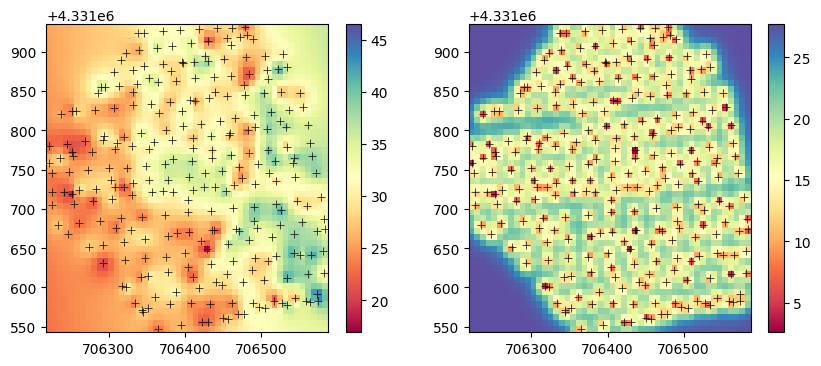

In [363]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
p1=plt.pcolormesh(X_pred, Y_pred, Z_pred,
               vmin=z_obs.min(), vmax=z_obs.max(),
              cmap='Spectral')
plt.scatter(x_obs, y_obs, marker='+', color='k', linewidth=0.5)
plt.colorbar(p1)

plt.subplot(1,2,2)
p2=plt.pcolormesh(X_pred, Y_pred, V_pred,
                vmin=V_pred.min(), vmax=V_pred.max(),
                cmap='Spectral')
plt.scatter(x_obs, y_obs, marker='+', color='k', linewidth=0.5)
plt.colorbar(p2)

plt.show()

## Note on simple versus ordinary kriging

In situations where we have a good trend model that accurately captures the underlying trend in the spatial dataset, the residuals should ideally contain no trend and only reflect spatial autocorrelation. Using simple kriging on these residuals can provide excellent results because the  assumptions are well-satisfied.

If the trend model fails to capture some aspects of the underlying trend, then the residuals will still contain some trend component. In this scenario, simple kriging might not be the best choice since its fundamental assumption (constant mean) is violated. In this scenario, ordinary kriging can be more robust method since it estimates a local mean for each prediction.

In summary, an accurate trend model coupled with simple kriging can provide excellent interpolation results. Ordinary kriging offers a more flexibility and robust method especially in datasets that exhibit complex spatial variability and where the trend model may not fully capture the underlying trend.